In [8]:
import numpy as np
import pandas as pd
import argparse
import warnings
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.ensemble import BaggingRegressor
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm import tqdm
from time import sleep, time
from sklearn.decomposition import PCA
def metric(y_true, y_pred):
    return np.mean(np.sum(np.abs(y_true - y_pred), axis=0)/np.sum(y_true, axis=0))

In [9]:
# parser = argparse.ArgumentParser()
# parser.add_argument(
#     "-tid", "--target_id", type=int, default=0,
#     help="target_id (default=0)")
# parser.add_argument(
#     "-f", "--feature_names", type=int, default=0)

# args = parser.parse_args()
# target_id = args.target_id
# feature_names = args.feature_names
p = Pool(processes=5)

feature_names = 4

target_id = 2
targets = ["age", "domain1_var1", "domain1_var2", "domain2_var1", "domain2_var2"]
target = targets[target_id]
weights = [0.3, 0.175, 0.175, 0.175, 0.175]
weight = weights[target_id]
best_alpha = [0.00026, 0.0041, 0.0041, 0.00205, 0.00205]
alpha = best_alpha[target_id]
print(target, weight, "feature_names:", feature_names, "alpha:", alpha)
fnc_df = pd.read_csv("../input/trends-assessment-prediction/fnc.csv")
loading_df = pd.read_csv("../input/trends-assessment-prediction/loading.csv")

fnc_features, loading_features = list(fnc_df.columns[1:]), list(loading_df.columns[1:])
df = fnc_df.merge(loading_df, on="Id")


labels_df = pd.read_csv("../input/trends-assessment-prediction/train_scores.csv")
labels_df["is_train"] = True

df = df.merge(labels_df, on="Id", how="left")

test_df = df[df["is_train"] != True].copy()
df = df[df["is_train"] == True].copy()

domain1_var2 0.175 feature_names: 4 alpha: 0.0041


In [10]:
# Giving less importance to FNC features since they are easier to overfit due to high dimensionality.
FNC_SCALE = 1/600

df[fnc_features] *= FNC_SCALE
test_df[fnc_features] *= FNC_SCALE

In [11]:
# print(fnc_features[:3], loading_features[:3])
# print(fnc_features[-3:], loading_features[-3:])
all_features = fnc_features + loading_features
all_df = pd.concat([df.loc[:, fnc_features, test_df.loc[:, fnc_features]], axis=0)
pca = PCA()
pca_all = pca.fit_transform(all_df)
score_samples = pca.score_samples(all_df)


In [19]:
# pca_all.shape
# score = pca.score(all_df)
# plt.plot(score)
scores = pca.explained_variance_ratio_
print(scores)

[1.41911674e-01 1.19445181e-01 1.01337473e-01 ... 8.34249120e-07
 8.09628611e-07 7.45877863e-07]


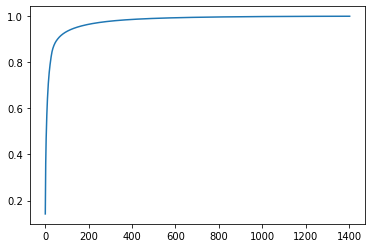

In [21]:
plt.plot(scores.cumsum())

In [10]:
# # To check the best alpha
# df_model = df.copy()
# max_iter = 1403
# NUM_FOLDS = 5
# kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=2020)

# features = loading_features + fnc_features
# max_features = len(features)

# ridge_beta = pd.DataFrame(np.zeros((max_iter, max_features + 2)), columns=features + ["intercept_", "alpha"])

# y_oof = np.zeros((df.shape[0], max_iter))
# y_preds = np.zeros((NUM_FOLDS, max_iter, df.shape[0]))
# y_scores = np.zeros((max_iter, NUM_FOLDS))
# scores = np.zeros(max_iter)  
# for i in tqdm(range(max_iter)):
#     _features = features[:max_features - i]
#     for f, (train_ind, val_ind) in enumerate(kf.split(df, df)):
#         train_df, val_df = df.iloc[train_ind], df.iloc[val_ind]
#         train_df = train_df[train_df[target].notnull()]

#         model = Ridge(alpha=alpha)
#         model.fit(train_df[_features].values, train_df[target].values)

#         val_pred = model.predict(val_df[_features])
#         y_preds[f, i] = model.predict(test_df[_features])
        
#         y_oof[val_ind, i] = val_pred
#         null_idx = val_df[target].notnull()
#         y_scores[i, f] = metric(val_df[target][null_idx].values, val_pred[null_idx]) * weight
#         if f == 0:
#             ridge_beta.loc[i, _features] = model.coef_
#             ridge_beta["intercept_"].iloc[i] = model.intercept_    


In [11]:

n_process = 15
df_model = df.copy()
max_iter = 1403
NUM_FOLDS = 5
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=2020)

features = loading_features + fnc_features
max_features = len(features)

ridge_beta = pd.DataFrame(np.zeros((max_iter, max_features + 2)), columns=features + ["intercept_", "alpha"])
alpha = 1e-6
alphas = []
for i in range(31):
    alphas.append(alpha)
    alpha *= 2

n_alpha = len(alphas)

# def search_best_alpha(_features, alpha, j):
#     for f, (train_ind, val_ind) in enumerate(kf.split(df, df)):
#         train_df, val_df = df.iloc[train_ind], df.iloc[val_ind]
#         train_df = train_df[train_df[target].notnull()]

#         model = Ridge(alpha=alpha)
#         model.fit(train_df[_features].values, train_df[target].values)

#         val_pred = model.predict(val_df[_features])
#         _y_oof[val_ind, j] = val_pred
#         _y_preds[f, j] = model.predict(test_df[_features])
#         null_idx = val_df[target].notnull()
#         _y_scores[j, f] = metric(val_pred[null_idx], val_df[target][null_idx].values) * weight
#         if f == 0:
#             _ridge_beta.loc[j, _features] = model.coef_
#             _ridge_beta.loc[j, ["intercept_"]] = model.intercept_
#             _ridge_beta.loc[j, ["alpha"]] = alpha
#     null_idx = df[target].notnull()
#     _scores[j] = metric(_y_oof[null_idx, j], df[target][null_idx].values) * weight
#     #__scores = metric(_y_oof[null_idx, j], df[target][null_idx].values) * weight
#     return _y_oof, _y_preds, _y_scores, _scores, _ridge_beta
def search_best_alpha(_features, alpha, j):
    for f, (train_ind, val_ind) in enumerate(kf.split(df, df)):
        train_df, val_df = df.iloc[train_ind], df.iloc[val_ind]
        train_df = train_df[train_df[target].notnull()]

        model = Ridge(alpha=alpha)
        model.fit(train_df[_features].values, train_df[target].values)

        val_pred = model.predict(val_df[_features])
        _y_oof[val_ind, j] = val_pred
        _y_preds[f, j] = model.predict(test_df[_features])
        null_idx = val_df[target].notnull()
        _y_scores[j, f] = metric(val_pred[null_idx], val_df[target][null_idx].values) * weight
        if f == 0:
            _ridge_beta.loc[j, _features] = model.coef_
            _ridge_beta.loc[j, ["intercept_"]] = model.intercept_
            _ridge_beta.loc[j, ["alpha"]] = alpha
    null_idx = df[target].notnull()
    _scores[j] = metric(_y_oof[null_idx, j], df[target][null_idx].values) * weight
    #__scores = metric(_y_oof[null_idx, j], df[target][null_idx].values) * weight
    return _y_oof[:, j], _y_preds[:, j], _y_scores[j], _scores[j], _ridge_beta.iloc[j].values

def wrap_search_best_alpha(args):
    return search_best_alpha(*args)

y_oof = np.zeros((df.shape[0], max_iter))
y_preds = np.zeros((df.shape[0], max_iter))
y_scores = np.zeros((max_iter, NUM_FOLDS))
scores = np.zeros(max_iter)
t_start = time()
for i in tqdm(range(max_iter)):
    _features = features[:max_features - i]
    _y_oof = np.zeros((df.shape[0], n_alpha))
    _y_preds = np.zeros((NUM_FOLDS, n_alpha, df.shape[0]))
    _y_scores = np.zeros((n_alpha, NUM_FOLDS))
    _scores = np.zeros(n_alpha)
    _ridge_beta = pd.DataFrame(np.zeros((n_alpha, max_features + 2)), columns=features + ["intercept_", "alpha"])
    job_args = [(_features, alphas[j], j) for j in range(31)]
    p = Pool(processes=n_process)
    for j, (__y_oof, __y_preds, __y_scores, __scores, __ridge_beta) in enumerate(p.imap(wrap_search_best_alpha, job_args)):
        _y_oof[:, j] = __y_oof
        _y_preds[:, j] = __y_preds
        _y_scores[j] = __y_scores
        _scores[j] = __scores
        _ridge_beta.iloc[j] = __ridge_beta
    p.close()
    p.join()
    best_alpha_idx = np.where(_scores == _scores.min())[0][0]
    y_oof[:, i] = _y_oof[:, best_alpha_idx]
    y_scores[i] = _y_scores[best_alpha_idx]
    scores[i] = _scores[best_alpha_idx]
    y_preds[:, i] = _y_preds[:, best_alpha_idx].mean(axis=0)
    ridge_beta.iloc[i] = _ridge_beta.iloc[best_alpha_idx]
    print(f"\n[INFO] i:{i}, score:{scores[i]:.5f}, alpha:{ridge_beta.loc[i, ['alpha']].values[0]:.5f}, total time:{time()-t_start:.1f}")
    if i == 1:
        break
    



0%|          | 1/1403 [00:36<14:23:53, 36.97s/it]
[INFO] i:0, score:0.02642, alpha:0.00410, total time:37.0
  0%|          | 1/1403 [01:13<28:42:30, 73.72s/it]
[INFO] i:1, score:0.02642, alpha:0.00410, total time:73.7



In [6]:
ridge_beta.loc[i, ['alpha']].values[0]

0.004096

In [26]:
# # To check the best alpha
# df_model = df.copy()
# max_iter = 1403
# NUM_FOLDS = 5
# kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=2020)

# features = loading_features + fnc_features
# max_features = len(features)

# ridge_beta = pd.DataFrame(np.zeros((max_iter, max_features + 2)), columns=features + ["intercept_", "alpha"])
# alpha = 1e-6
# alphas = []
# for i in range(31):
#     alphas.append(alpha)
#     alpha *= 2

# n_alpha = len(alphas)

# y_oof = np.zeros((df.shape[0], max_iter))
# y_preds = np.zeros((df.shape[0], max_iter))
# y_scores = np.zeros((max_iter, NUM_FOLDS))
# scores = np.zeros(max_iter)  
# for i in tqdm(range(max_iter)):
#     _features = features[:max_features - i]
#     _y_oof = np.zeros((df.shape[0], n_alpha))
#     _y_preds = np.zeros((NUM_FOLDS, n_alpha, df.shape[0]))
#     _y_scores = np.zeros((n_alpha, NUM_FOLDS))
#     _scores = np.zeros(n_alpha)
#     _ridge_beta = pd.DataFrame(np.zeros((n_alpha, max_features + 2)), columns=features + ["intercept_", "alpha"])

#     for j, alpha in enumerate(alphas):
#         for f, (train_ind, val_ind) in enumerate(kf.split(df, df)):
#             train_df, val_df = df.iloc[train_ind], df.iloc[val_ind]
#             train_df = train_df[train_df[target].notnull()]

#             model = Ridge(alpha=alpha)
#             model.fit(train_df[_features].values, train_df[target].values)

#             val_pred = model.predict(val_df[_features])
#             _y_oof[val_ind, j] = val_pred
#             _y_preds[f, j] = model.predict(test_df[_features])
#             null_idx = val_df[target].notnull()
#             _y_scores[j, f] = metric(val_pred[null_idx], val_df[target][null_idx].values) * weight
#             if f == 0:
#                 _ridge_beta.loc[j, _features] = model.coef_
#                 _ridge_beta.loc[j, ["intercept_"]] = model.intercept_
#                 _ridge_beta.loc[j, ["alpha"]] = alpha
#             alpha *= 2
#         null_idx = df[target].notnull()
#         _scores[j] = metric(_y_oof[null_idx, j], df[target][null_idx].values) * weight
#     best_alpha_idx = np.where(_y_scores == _y_scores.min())[0][0]
#     y_oof[:, i] = _y_oof[:, best_alpha_idx]
#     y_scores[i] = _y_scores[best_alpha_idx]
#     scores[i] = _scores[best_alpha_idx]
#     y_preds[:, i] = _y_preds[:, best_alpha_idx].mean(axis=0)
#     ridge_beta.iloc[i] = _ridge_beta.iloc[best_alpha_idx]

#     if i == 1:
#         break


0%|          | 1/1403 [03:28<81:04:52, 208.20s/it]


In [49]:
alpha = 1e-6
alphas = []
for i in range(31):
    alphas.append(alpha)
    alpha *= 2

tmp = np.zeros((3, 11))
print("tmp:", tmp)
def p_check(alpha, j):
    print(i-1, j, alpha)
    _tmp = alpha
    #sleep(np.random.randint(0, 4))
    return _tmp, j

def wrap_p_check(args):
    return p_check(*args)

for i in range(1, 4):
    job_args = [(alphas[int(j*i)], int(j*i)) for j in range(10)]
    p = Pool(processes=5)
    for k, (alpha, j) in enumerate(p.imap(wrap_p_check, job_args)):
        tmp[i-1, k] = alpha
    p.close()
    p.join()
    print("tmp:", list(tmp))


tmp: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
0 0 1e-06
0 3 8e-06
0 2 4e-06
0 1 2e-06
0 4 1.6e-05
0 5 3.2e-05
0 6 6.4e-05
0 7 0.000128
0 8 0.000256
0 9 0.000512
tmp: [array([1.00e-06, 2.00e-06, 4.00e-06, 8.00e-06, 1.60e-05, 3.20e-05,
       6.40e-05, 1.28e-04, 2.56e-04, 5.12e-04, 0.00e+00]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]
1 4 1.6e-05
1 6 6.4e-05
1 8 0.000256
1 0 1e-06
1 10 0.001024
1 12 0.004096
1 2 4e-06
1 14 0.016384
1 16 0.065536
1 18 0.262144
tmp: [array([1.00e-06, 2.00e-06, 4.00e-06, 8.00e-06, 1.60e-05, 3.20e-05,
       6.40e-05, 1.28e-04, 2.56e-04, 5.12e-04, 0.00e+00]), array([1.00000e-06, 4.00000e-06, 1.60000e-05, 6.40000e-05, 2.56000e-04,
       1.02400e-03, 4.09600e-03, 1.63840e-02, 6.55360e-02, 2.62144e-01,
       0.00000e+00]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]
2 0 1e-06
2 6 6.4e-05
2 3 8e-06
2 9 0.000512
2 12 0.004

In [44]:
tmp_i.next()

(1e-06, 0)

In [36]:
# for i in range(max_iter):
#     null_idx = df[target].notnull().values
#     y_oof_not_null = y_oof[null_idx, i]
#     y_true = df[null_idx][target].values
#     scores[i] = metric(y_oof_not_null, y_true) * weight

best score CV:0.00000, n_feature:2 in domain1_var2


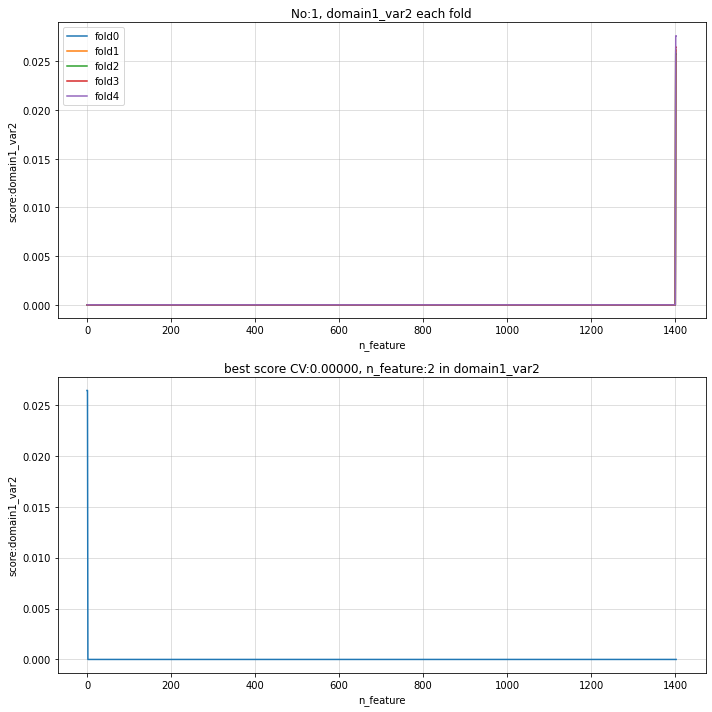

In [64]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
for f in range(NUM_FOLDS):
    plt.plot(np.arange(max_iter-1, -1, -1), y_scores[:, f], label=f"fold{f}")
plt.legend()
plt.xlabel('n_feature')
plt.ylabel(f'score:{target}')
plt.grid(alpha=0.5)
plt.title(f'No:{feature_names}, {target} each fold')
plt.tight_layout()

plt.subplot(2, 1, 2)
plt.plot(np.arange(max_iter), scores)
plt.xlabel('n_feature')
plt.ylabel(f'score:{target}')
plt.grid(alpha=0.5)
best_idx = np.where(scores == scores.min())[0][0]
plt.title(f'best score CV:{scores[best_idx]:.5f}, n_feature:{np.arange(max_iter)[best_idx]:d} in {target}')
plt.tight_layout()
plt.savefig(f"ridge_results/{target}_No{feature_names}_CV.png")

print(f'best score CV:{scores[best_idx]:.5f}, n_feature:{np.arange(max_iter)[best_idx]:d} in {target}')
valid_df = pd.DataFrame(np.zeros((df.shape[0], 2)), columns=["Id", f"{target}_pred"])
valid_df['Id'] = df.Id.values
valid_df[f"{target}_pred"] = y_oof[:, best_idx]
valid_df.to_csv(f"ridge_results/val_{target}_No{feature_names}_CV.csv", index=False)
pred_df = pd.DataFrame(np.zeros((test_df.shape[0], 2)), columns=["Id", f"{target}_pred"])
pred_df['Id'] = test_df.Id.values
pred_df[f"{target}_pred"] = y_preds[best_idx]
pred_df.to_csv(f"ridge_results/pred_{target}_No{feature_names}_CV.csv", index=False)

In [68]:
best_idx

2

In [69]:
valid_df

,Id,domain1_var2_pred
0,10001,0.0
1,10002,0.0
2,10004,0.0
3,10005,0.0
4,10007,0.0
...,...,...
5872,21746,0.0
5873,21747,0.0
5874,21750,0.0
5875,21752,0.0


In [ ]:
val_df